<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/master/2021/hw/hw1/img/logo_hse.png?raw=1" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 4: Прогнозирование временных рядов</center></h2>

# Введение

В этом задании Вам предстоит разобраться с основами анализа и прогнозирования временных рядов. 


![image](https://imgs.xkcd.com/comics/extrapolating.png)

In [102]:
!pip install orbit-ml
!pip install prophet
!pip install sktime[all_extras]

  Using cached https://files.pythonhosted.org/packages/23/3d/db9a6b3c83c9511301152dbb64a029c3a4313c86eaef12c237b13ecf91d6/matplotlib-3.3.4-cp37-cp37m-manylinux1_x86_64.whl
ERROR: prophet 1.0.1 has requirement cmdstanpy==0.9.68, but you'll have cmdstanpy 0.9.5 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: matplotlib 3.1.3
    Uninstalling matplotlib-3.1.3:
      Successfully uninstalled matplotlib-3.1.3


  Using cached https://files.pythonhosted.org/packages/08/b9/b4f0938b38dbe775c4def707f525ab816b9d0215ecd8ab2d76780f4514f8/cmdstanpy-0.9.68-py3-none-any.whl
ERROR: fbprophet 0.7.1 has requirement cmdstanpy==0.9.5, but you'll have cmdstanpy 0.9.68 which is incompatible.
  Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
  Using cached https://files.pythonhosted.org/packages/e3/e2/204c9c6beaf9e05ad28bd589c154afff35dffa6166d76841d3c0dec6c1e3/cmdstanpy-0.9.5-py3-none-any.whl
ERROR: prophet 1.0.1 has requirement cmdstanpy==0.9.68, but you'll have cmdstanpy 0.9.5 which is incompatible.
  Found existing installation: cmdstanpy 0.9.68
    Uninstalling cmdstanpy-0.9.68:
      Successfully uninstalled cmdstanpy-0.9.68


In [103]:
%matplotlib inline

from IPython import display
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np


## Задание 1 (2 балла). Поиск и предобработка данных.

В этом задании Вам необходимо _самостоятельно_ найти два временных ряда: один должен обладать месячной частотой, а второй — дневной.

Мы советуем поискать соответствующие временные ряды на платформе [kaggle](https://www.kaggle.com/datasets) или же взять один из [популярных](https://medium.com/analytics-vidhya/10-time-series-datasets-for-practice-d14fec9f21bc) временных рядов для анализа. 

**Не рекоммендуется** использовать в качестве временных рядов цены финансовых инструментов в силу плохой предсказуемости изменения цен. **Запрещается** использовать готовые наборы данных из библиотек для анализа временных рядов, например, `from orbit.utils.dataset import load_iclaims`.

![bitcoin](https://avatars.mds.yandex.net/get-zen_doc/3417386/pub_6017dd4b8d30cb1780864ae0_6017f4aa8d30cb1780bf66ce/scale_1200)




В качестве отчета по заданию:

* Опишите источники временных рядов (ссылки на страницы скачивания). В случае, если данные требовали дополнительной обработки, приведите код этой обработки, загрузите данные в личное облачное хранилище и приведите ссылку на скачивание. Процесс получения временных рядов должен быть **четко** расписан и полностью **воспроизводиться**. 

* Приведите код считывания временных рядов из файлов и разделения на train/test. Соотношение размеров train/test на Ваше усмотрение, но мы советуем Вам выбрать 80% на 20%, если в test остаётся хотя бы пара лет наблюдений.



In [130]:
# считаем файлы
ts1 = pd.read_csv('https://raw.githubusercontent.com/aromana33/hw7_dl_2021/main/international-airline-passengers.csv', index_col=0)
ts1 = ts1[:-1]
ts1.index = pd.to_datetime(ts1.index, format = '%Y-%m', infer_datetime_format=True)
ts1 = ts1.rename(columns={'International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60': 'value'})
ts1.index = pd.to_datetime(ts1.index, format = '%y-%b')
ts2 = pd.read_csv('https://raw.githubusercontent.com/aromana33/hw7_dl_2021/main/daily-website-visitors.csv', index_col=0)
ts2 = ts2[['Date', 'Page.Loads']] 
ts2 = ts2.rename(columns={'Page.Loads': 'value'})
ts2['Date'] = pd.to_datetime(ts2['Date'])
ts2 = ts2.set_index('Date')
ts2['value'] = ts2['value'].str.split(',').str.join('').astype(int)

In [141]:
ts1 = pd.read_csv('https://raw.githubusercontent.com/aromana33/hw7_dl_2021/main/candy_production.csv', index_col=0)

In [143]:
ts1 = ts1.rename(columns={'IPG3113N': 'value'})
ts1.index = pd.to_datetime(ts1.index,  infer_datetime_format=True)

,value
observation_date,
1972-01-01,85.6945
1972-02-01,71.8200
1972-03-01,66.0229
1972-04-01,64.5645
1972-05-01,65.0100
...,...
2017-04-01,107.4288
2017-05-01,101.9209
2017-06-01,104.2022


In [144]:
# сделаем разбиение на train/test
from sktime.forecasting.model_selection import temporal_train_test_split
day_train, day_test = temporal_train_test_split(ts2['value'], test_size=0.2)
month_train, month_test = temporal_train_test_split(ts1['value'], test_size=0.2)

## Задание 2. Анализ временных рядов (1 балла).

* Отрисуйте временные ряды и визуально сделайте различимым разбиение на выборки — либо вертикальной чертой, либо разными цветами.

* Постройте графики автокорреляционных функций для выбранных временных рядов. Прокомментируйте их: являются ли временные ряды сезонными? Видна ли на графиках длина сезонной составляющей ряда?

* В случае присутствия сезонности, разбейте временной ряд на повторяющиеся фрагменты и нарисуйте их наложенными для иллюстрации этой сезонности.

In [39]:
# !pip install matplotlib==3.1.3

### Отрисуем временные ряды, разделив их цветом
---

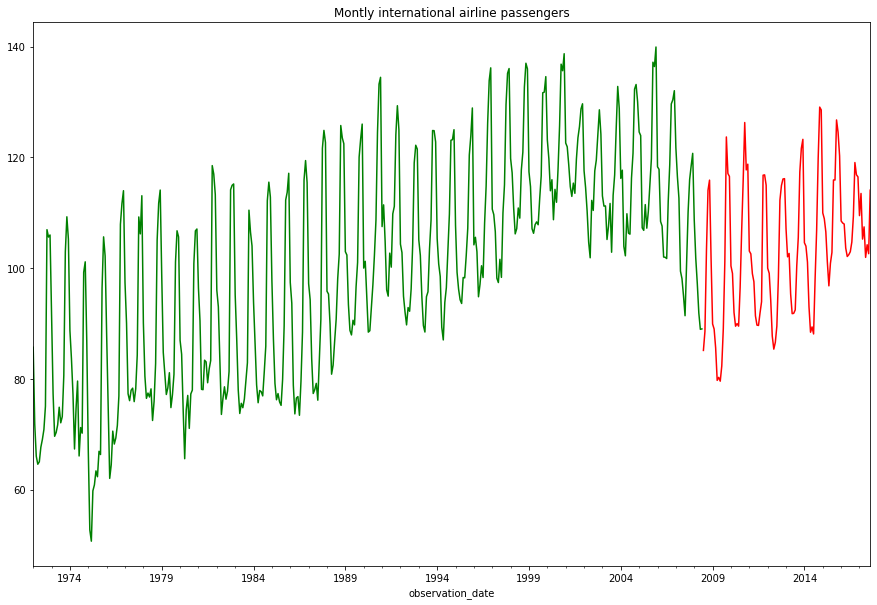

In [145]:
fig, ax = plt.subplots(1,1, figsize=(15, 10))
month_train.plot(ax=ax, label='train', color='g', title='Montly international airline passengers')
month_test.plot(ax=ax, label='test', color='r');


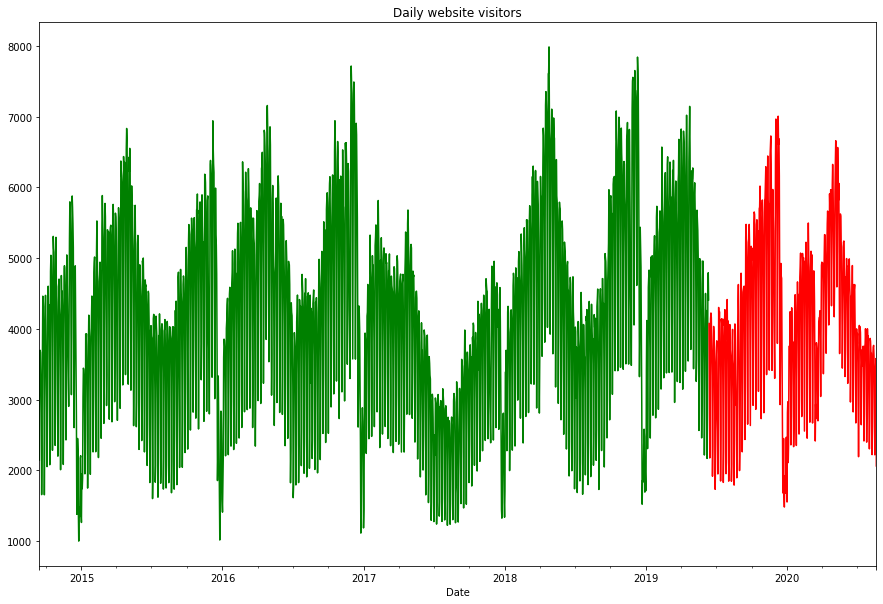

In [107]:
fig, ax = plt.subplots(1,1, figsize=(15, 10))
day_train.plot(ax=ax, label='train', color='g', title='Daily website visitors')
day_test.plot(ax=ax, label='test', color='r');

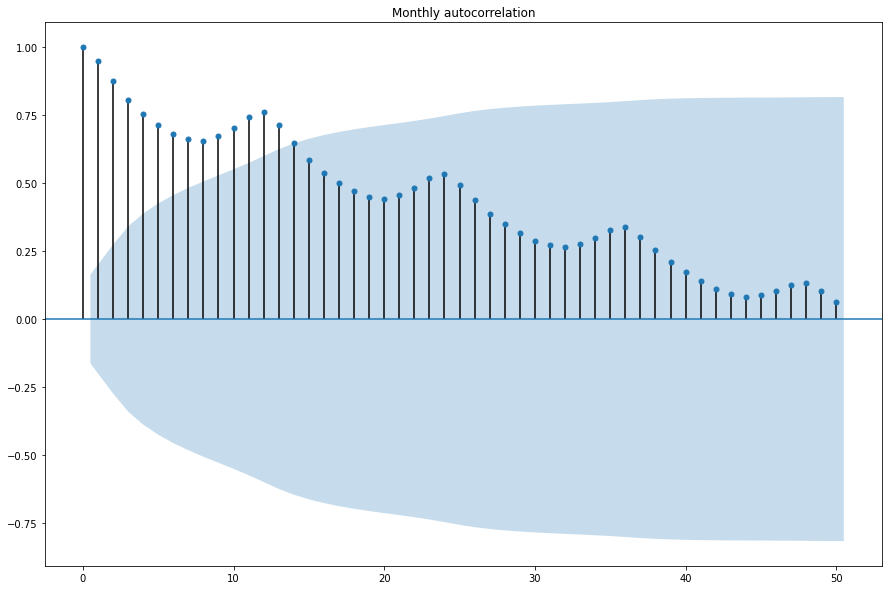

In [108]:
# посчитайте и нарисуйте график автокорреляционной функции
# hint, используйте для этого np.correlate(..., mode='full')

# воспользуемся готовым методом для отрисовки автокорреляционной функции6 спасибо Борису Борисовичу
from statsmodels.graphics.tsaplots import plot_acf

with plt.rc_context():
    plt.rc("figure", figsize=(15,10))
    plot_acf(ts1['value'], lags=50, title='Monthly autocorrelation');

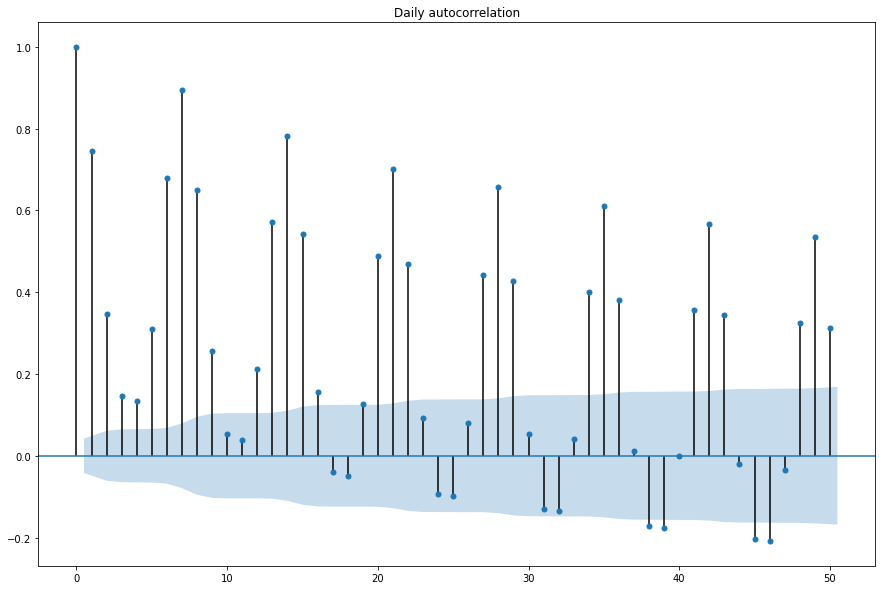

In [109]:
with plt.rc_context():
    plt.rc("figure", figsize=(15,10))
    plot_acf(ts2['value'], lags=50, title='Daily autocorrelation');

In [110]:
# разбейте временной ряд на повторяющиеся участки по длине сезонной составляющей и нарисуйте их наложенными

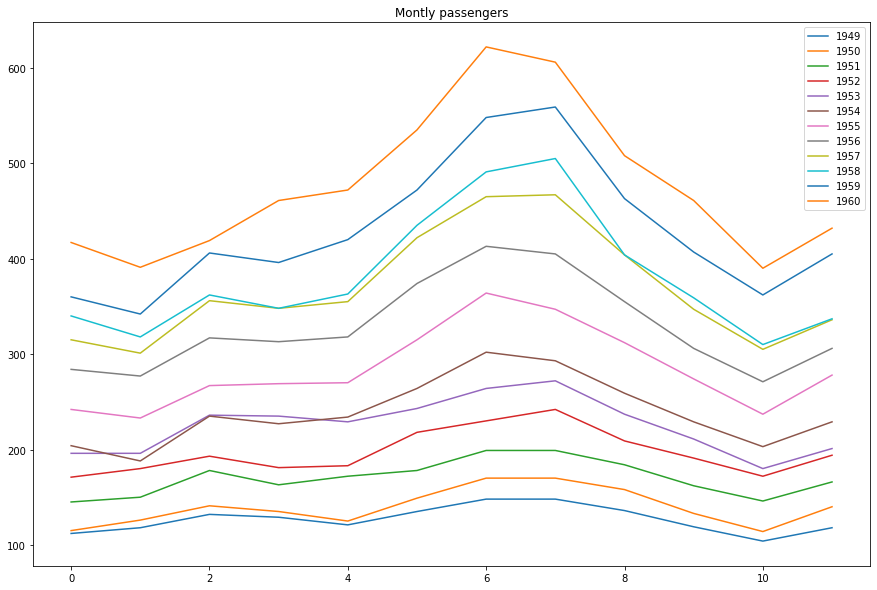

In [111]:
fig, ax = plt.subplots(1,1, figsize=(15, 10))
for year in np.arange(1949, 1961):
  arr = ts1[ts1.index.year == year].to_numpy()
  plt.plot(arr, label=str(year))
  plt.title('Montly passengers')
  plt.legend();

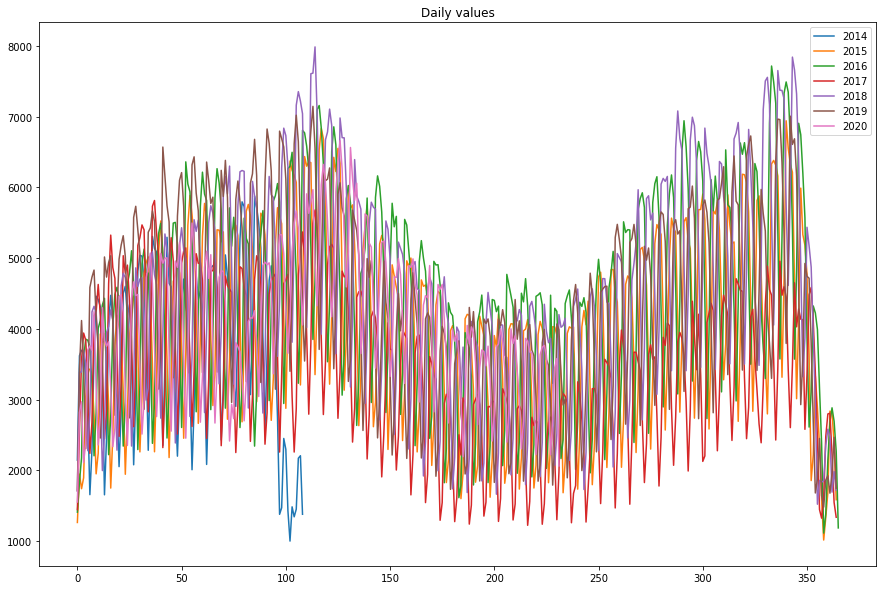

In [112]:
fig, ax = plt.subplots(1,1, figsize=(15, 10))
for year in np.arange(2014, 2021):
  arr = ts2[ts2.index.year == year].to_numpy()
  plt.plot(arr, label=str(year))
  plt.title('Daily values')
  plt.legend();

## Задание 3. Предсказание месячного временного ряда (4.5 балла).

В этом задании Вам предстоит попробовать предсказать месячный временной несколькими готовыми моделями со скользящим или растущим окном и выбрать среди них наилучшую.

В качестве метрики сравнения используйте MAE между истинными и предсказанными значениями ряда на тестовом отрезке.


### NaiveForecaster из sktime (0.5 балл).

Посчитайте предсказания следующими двумя наивными способами:

* $\hat{y}_{t+1} = y_{t}$
* $\hat{y}_{t+1} = y_{t-seasonality+1}$

In [113]:
from sktime.forecasting.naive import NaiveForecaster
from sklearn.metrics import mean_absolute_error as MAE
from sktime.forecasting.base import ForecastingHorizon


## 1 наивный способ

$\hat{y}_{t+1} = y_{t}$

In [178]:
fh = ForecastingHorizon(month_test.asfreq('m').index, is_relative=True)
fh

TypeError: ignored

In [172]:
month_test.index

DatetimeIndex(['2008-07-01', '2008-08-01', '2008-09-01', '2008-10-01',
               '2008-11-01', '2008-12-01', '2009-01-01', '2009-02-01',
               '2009-03-01', '2009-04-01',
               ...
               '2016-11-01', '2016-12-01', '2017-01-01', '2017-02-01',
               '2017-03-01', '2017-04-01', '2017-05-01', '2017-06-01',
               '2017-07-01', '2017-08-01'],
              dtype='datetime64[ns]', name='observation_date', length=110, freq=None)

In [167]:
month_train.index = month_train.asfreq('m').index

In [169]:
forecaster = NaiveForecaster(strategy="last", sp=1)
forecaster.fit(month_train)
preds = forecaster.predict(fh)

AssertionError: ignored

In [ ]:

print(f'MAE={MAE(preds, month_test)}')

## 2 наивный способ

$\hat{y}_{t+1} = y_{t-seasonality+1}$

In [ ]:
forecaster = NaiveForecaster(strategy="last")
forecaster.fit(month_train)
preds = forecaster.predict(fh)

In [ ]:

print(f'MAE={MAE(preds, month_test)}')

### ARIMA/AutoArima (1 балл).

Обучите из библиотеки `sktime` модели:

* SARIMA(1, 1, 1)(1, 0, 0)[12] (`ARIMA` в `sktime`)
* Алгоритм Хиндмана-Хандакара подбора SARIMA (`AutoARIMA` в `sktime`)

In [163]:
month_train.index

DatetimeIndex(['1972-01-01', '1972-02-01', '1972-03-01', '1972-04-01',
               '1972-05-01', '1972-06-01', '1972-07-01', '1972-08-01',
               '1972-09-01', '1972-10-01',
               ...
               '2007-09-01', '2007-10-01', '2007-11-01', '2007-12-01',
               '2008-01-01', '2008-02-01', '2008-03-01', '2008-04-01',
               '2008-05-01', '2008-06-01'],
              dtype='datetime64[ns]', name='observation_date', length=438, freq=None)

In [140]:
from sktime.forecasting.arima import ARIMA, AutoARIMA

forecaster = ARIMA(order=(1, 1, 1), 
                   seasonal_order=(1, 0, 0, 12), 
                   suppress_warnings=True)
forecaster.fit(month_train)
preds = forecaster.predict(fh)

AttributeError: ignored

In [ ]:
# посчитайте метрики на test

### LGT/DLT (1 балл).

Обучите из библиотеки `orbit` модели LGT и DLT

In [ ]:
from orbit.models.lgt import LGTFull
from orbit.models.dlt import DLTFull


# ваш код обучения моделей здесь

,value
1972-01-01,85.6945
1972-02-01,71.8200
1972-03-01,66.0229
1972-04-01,64.5645
1972-05-01,65.0100
...,...
2008-02-01,101.7820
2008-03-01,97.2060
2008-04-01,91.8637
2008-05-01,88.9254


In [174]:
ts1.index[:len(month_train)]

DatetimeIndex(['1972-01-01', '1972-02-01', '1972-03-01', '1972-04-01',
               '1972-05-01', '1972-06-01', '1972-07-01', '1972-08-01',
               '1972-09-01', '1972-10-01',
               ...
               '2007-09-01', '2007-10-01', '2007-11-01', '2007-12-01',
               '2008-01-01', '2008-02-01', '2008-03-01', '2008-04-01',
               '2008-05-01', '2008-06-01'],
              dtype='datetime64[ns]', name='observation_date', length=438, freq=None)

In [177]:
month_train1 = pd.DataFrame(month_train.reset_index()['value'].tolist(), list(ts1.index[:len(month_train)]), columns=['value'])
month_train1 = month_train1.reset_index() 
month_test1 = pd.DataFrame(month_test.reset_index()['value'].tolist(), list(ts1.index[:len(month_train)]), columns=['value'])
month_test1 = month_test1.reset_index() 

In [ ]:
# посчитайте метрики на test

### ETS (2 балла).

Обучите из библиотеки `sklearn` модели:

* ETS(AAA) (`ExponentialSmoothing` в `sktime`)
* ETS с автоматическим выбором по AIC (`AutoETS` в `sktime`)

In [ ]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.ets import AutoETS

# ваш код обучения моделей здесь

In [ ]:
# посчитайте метрики на test

Нарисуйте для наилучшей модели предсказания с доверительным интервалом (если модель выдает его) и наложите их на истинные значения. В `sktime` `ETS` модель пока ещё не выдаёт доверительные интервалы, но при желании до них можно дотянуться :)

In [ ]:
# нарисуйте пресказания

## Задание 4. Предсказание дневного временного ряда (2.5 балла).

В этом задании Вам предстоит попробовать предсказать выбранный Вами дневной временной ряд.

Аналогично, в качестве метрики используем MAE.



### NaiveForecaster из sktime (0.5 балла).

Посчитайте предсказания следующими двумя наивными способами:

* $\hat{y}_{t+1} = y_{t}$
* $\hat{y}_{t+1} = y_{t-seasonality+1}$

In [ ]:
from sktime.forecasting.naive import NaiveForecaster

# ваш код обучения моделей здесь

In [ ]:
# посчитайте метрики на test

### KTR из orbit (1 балл).



In [ ]:
from orbit.models.ktrlite import KTRLiteMAP

# ваш код обучения моделей здесь

In [ ]:
# посчитайте метрики на test

### Phophet (1 балл).



In [ ]:
from prophet import Prophet

# ваш код обучения моделей здесь

In [ ]:
# посчитайте метрики на test

Нарисуйте для наилучшей модели предсказания с доверительным интервалом (если модель выдает его) и наложите их на истинные значения.

In [ ]:
# нарисуйте пресказания

## Бонус. Напишите свою модель на STAN (3 балла).

Разработайте и испытай свою модель для месячного ряда в STAN.

Сравните качество прогнозов с наивной сезонной на тестовой выборке с помощью MAE. 



In [ ]:
# ваш код модели на STAN и её обучения моделей здесь

In [ ]:
# посчитайте метрики на test

In [ ]:
# нарисуйте пресказания